# This is a sample Jupyter Notebook



In [128]:
!python --version

Python 3.9.19


# Prepare the data

In [129]:
import pandas as pd
# Have a look at the data
df = pd.read_csv('data\Environment variables-data-as-seriestocolumns-2022-03-01 16_36_12.csv')
df.shape


(62724, 4)

In [130]:
df.head()

,Time,TF.insideEnvironment.insideHumidity,TF.insideEnvironment.insideLight,TF.insideEnvironment.insideTemperature
0,2022-02-28 06:00:01,29.0,0.14,25.0
1,2022-02-28 06:00:01,29.0,NaN,NaN
2,2022-02-28 06:00:05,29.0,NaN,NaN
3,2022-02-28 06:00:06,29.0,NaN,NaN
4,2022-02-28 06:00:11,29.0,NaN,NaN


In Excel I had a look over the data and saw lots of duplicates and missing values. I will have to clean the data before I can work with it.

In [131]:
df.drop_duplicates(inplace=True)
df.shape

(43471, 4)

In [132]:
# count the duplicates that are left
df.duplicated().sum()

0

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43471 entries, 0 to 62722
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Time                                    43471 non-null  object 
 1   TF.insideEnvironment.insideHumidity     23816 non-null  float64
 2   TF.insideEnvironment.insideLight        10153 non-null  float64
 3   TF.insideEnvironment.insideTemperature  9508 non-null   float64
dtypes: float64(3), object(1)
memory usage: 1.7+ MB


So we have a different amount of data points for each column. We will have to interpolate the data to get a consistent dataset.
But first lets rename the columns to make them more readable.

In [134]:
#rename the columns
df.columns = ['Time', 'Humidity', 'Light', 'Temperature']
df.head()

,Time,Humidity,Light,Temperature
0,2022-02-28 06:00:01,29.0,0.14,25.0
1,2022-02-28 06:00:01,29.0,NaN,NaN
2,2022-02-28 06:00:05,29.0,NaN,NaN
3,2022-02-28 06:00:06,29.0,NaN,NaN
4,2022-02-28 06:00:11,29.0,NaN,NaN


# Visualize the data, Interpolating

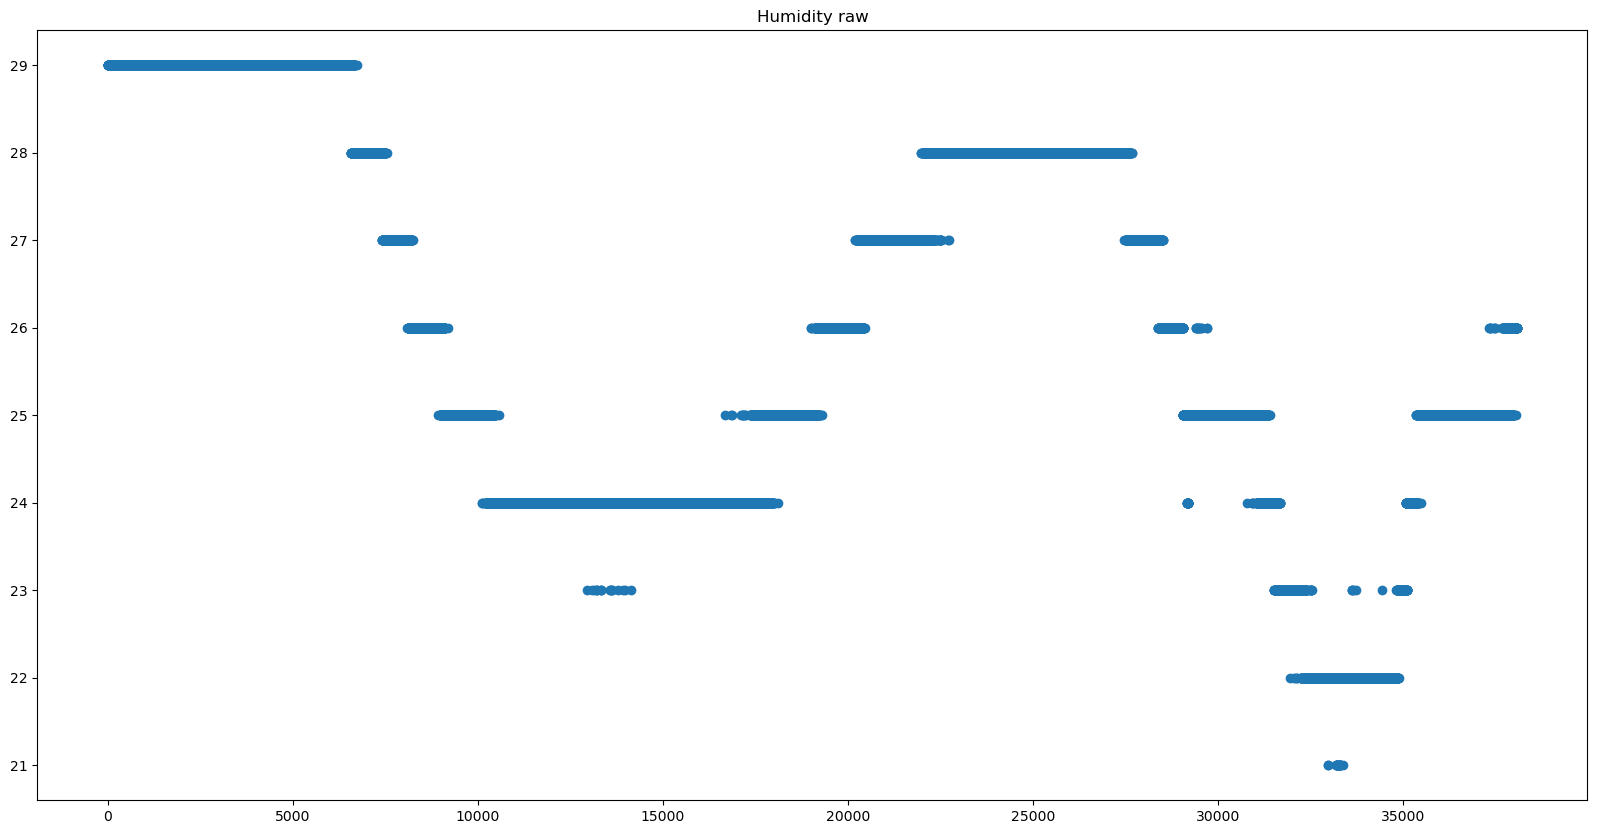

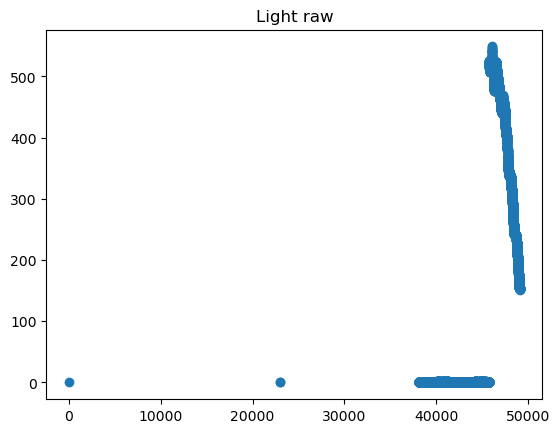

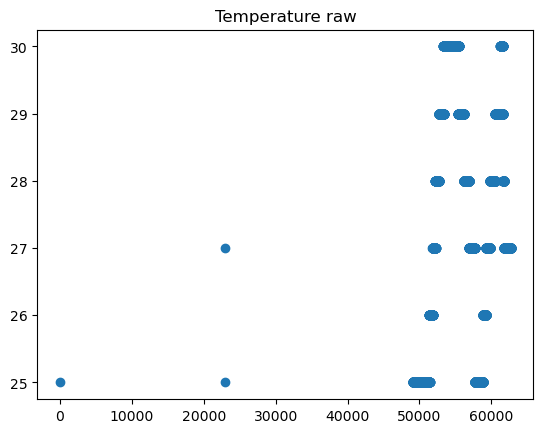

In [135]:
# import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity raw')
plt.show()
plt.plot(df['Light'], marker='o', linestyle='', label='Light')
plt.title('Light raw')
plt.show()
plt.plot(df['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature raw')
plt.show()

In [136]:
# to be able to use method 'time' we need to convert the Time column to datetime
df['Time'] = pd.to_datetime(df['Time'])
# set the Time column as index
df.set_index('Time', inplace=True)

# interpolate the data
df_ip = df.copy()
df_ip.interpolate(method='time', inplace=True)
df_ip.head()


,Humidity,Light,Temperature
Time,,,
2022-02-28 06:00:01,29.0,0.140000,25.0
2022-02-28 06:00:01,29.0,0.140000,25.0
2022-02-28 06:00:05,29.0,0.140149,25.0
2022-02-28 06:00:06,29.0,0.140186,25.0
2022-02-28 06:00:11,29.0,0.140372,25.0


In [137]:
# resample the data to have a consistent time interval
df_ip = df_ip.resample('30min').mean()
df_ip.loc['2022-02-28']

,Humidity,Light,Temperature
Time,,,
2022-02-28 06:00:00,29.000000,0.175445,25.000000
2022-02-28 06:30:00,29.000000,0.238253,25.000000
2022-02-28 07:00:00,29.000000,0.269863,25.000000
2022-02-28 07:30:00,29.000000,0.356335,25.000000
2022-02-28 08:00:00,29.000000,0.487966,25.000000
2022-02-28 08:30:00,29.000000,0.573315,25.000000
2022-02-28 09:00:00,29.000000,0.782015,25.000000
2022-02-28 09:30:00,29.000000,1.145044,25.000000
2022-02-28 10:00:00,29.000000,1.172823,25.001064


In [138]:
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2022-02-28 06:00:00 to 2022-03-01 16:30:00
Freq: 30min
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Humidity     55 non-null     float64
 1   Light        55 non-null     float64
 2   Temperature  55 non-null     float64
dtypes: float64(3)
memory usage: 2.2 KB


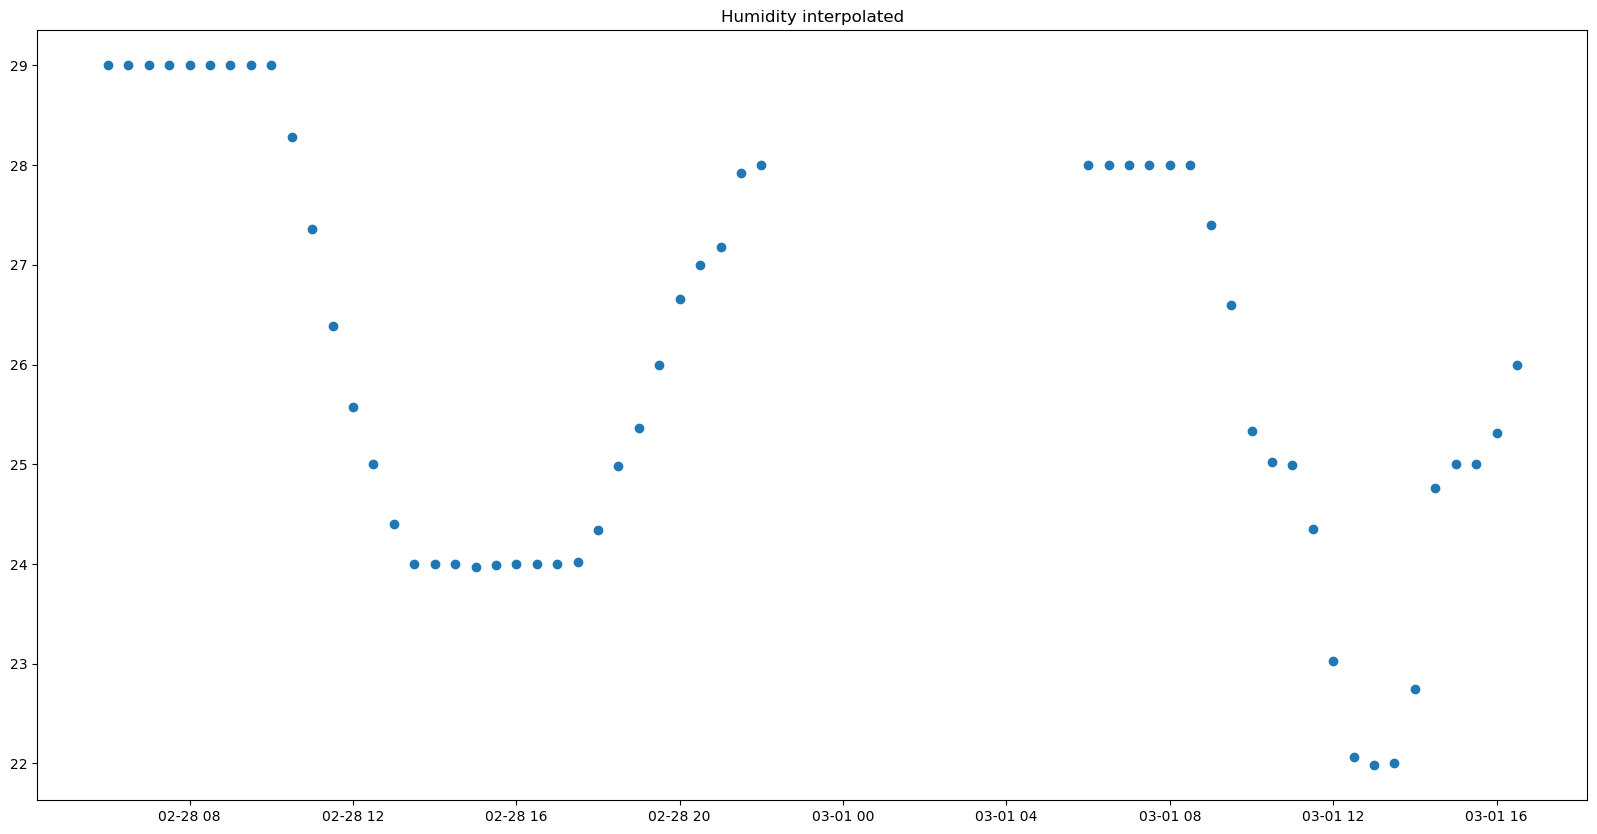

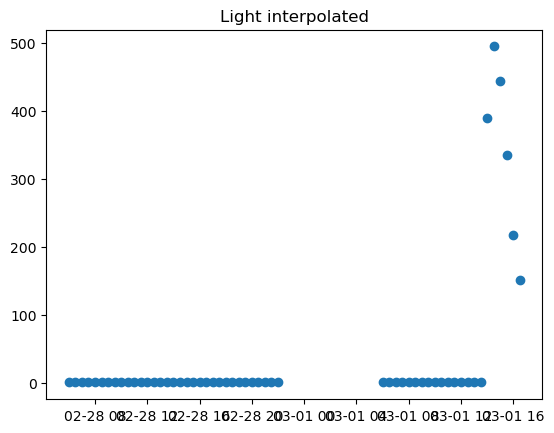

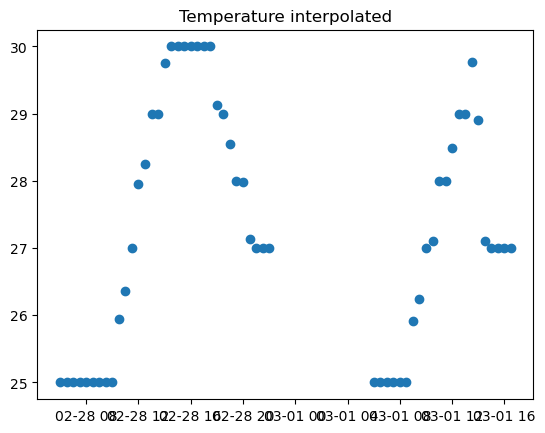

In [139]:
plt.figure(figsize=(20,10))
plt.plot(df_ip['Humidity'], marker='o', linestyle='', label='Humidity')
plt.title('Humidity interpolated')
plt.show()
plt.plot(df_ip['Light'], marker='o', linestyle='', label='Humidity')
plt.title('Light interpolated')
plt.show()
plt.plot(df_ip['Temperature'], marker='o', linestyle='', label='Temperature')
plt.title('Temperature interpolated')
plt.show()

The interpolated data looks much better. Still weird, that we have this gap in the data. But at least it's a consistent gap.

In [140]:
df_ip.describe()

,Humidity,Light,Temperature
count,55.000000,55.000000,55.000000
mean,26.018919,37.590990,27.301791
std,2.130587,113.575547,1.804192
min,21.981841,0.140000,25.000000
25%,24.178952,0.254193,25.001198
50%,25.574679,1.043531,27.000021
75%,28.000000,1.318300,29.000000
max,29.000000,494.511384,30.000000


# Preparing the data for the model

In [160]:
# create lagged features
humidity = df_ip['Humidity']
df_ip.to_csv('data\df_ip.csv')
# data_humidity = pd.concat([humidity.shift(1), humidity], axis=1)
# data_humidity.info()
# data_humidity = pd.concat([humidity.shift(7), humidity.shift(6), humidity.shift(5), humidity.shift(4), humidity.shift(3), humidity.shift(2), humidity.shift(1), humidity], axis=1)
# data_humidity.columns = ['t-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'humidity']

# write a for loop to create 48 lagged features
# data_humidity = pd.DataFrame()
# for i in range(48):
#     data_humidity = pd.concat([data_humidity, humidity.shift(48-i)], axis=1)
#     data_humidity.rename(columns={data_humidity.columns[i]: f't-{48-i}'}, inplace=True)
# 
# data_humidity.info()





